# Fourth exercise: Markov state modelling
Data source: climate evolution on the geological time scale https://drive.google.com/file/d/1nMr4XdOXo3Xfs5zAJPczm7h0fXVwUsUl/edit 

In [1]:
# importing libraries
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
plt.rcParams.update({
  "text.usetex": True
})
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
import seaborn as sns
import random
import pickle 
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 

import sys
sys.path.append('../')
from _1.first_exercise import get_PC, get_spectrum, plot_PC, plot_log_spectrum, normalize
from _2.second_exercise import mutual_information
from _3.third_exercise import update_centroids, random_init, k_means, k_means_repeated, scree_plot, k_plus_plus

In [2]:
# load the data
X = np.loadtxt('data/airT_dec5.dat')
print("Dimension of the dataset: ", X.shape)
# center dataset 
X = X - X.mean(axis=0)


Dimension of the dataset:  (21578, 96)


1. Find the microstates by a cluster analysis performed with k-means or k-medoids. Optionally, perform a preliminary dimensional reduction using PCA.

In [3]:
# PCA preliminary analysis
Y_all = get_PC(X, X.shape[1], plot=False)  
# spectrum of cov(X)
evalues, evectors = get_spectrum(Y_all) # spectrum of cov(Y)
# proportion of variance explained
exp_var = np.cumsum(evalues)/np.sum(evalues)
# number of PC to account for the 99.5% of variance
n_PC = np.where(exp_var>=0.995)[0][0]
# reduce dimensionality of the dataset
X = get_PC(X, n_PC) 
print("New dimension of the dataset: ", X.shape)


New dimension of the dataset:  (21578, 4)


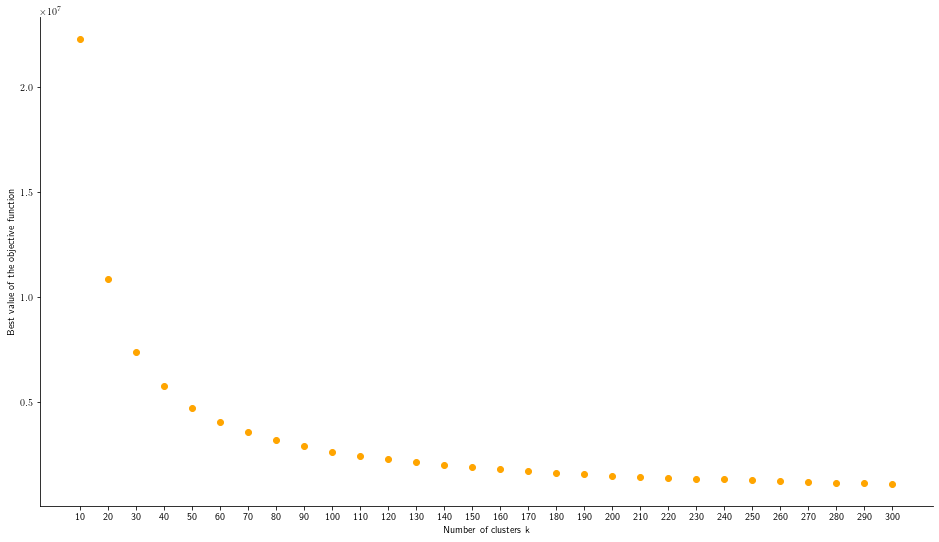

In [4]:
# scree plot to guide the choice of the number of clusters
'''
objs = []
for k in range(10, 301, 10):
    _, obj_i, _, _ = k_means_repeated(X, k_plus_plus, update_centroids, k=k)
    objs.append(obj_i)

with open('data/k_means_objectives.pkl', 'wb') as f:
     pickle.dump(objs, f)
'''
with open('data/k_means_objectives.pkl', 'rb') as f:
    objectives = pickle.load(f)

objectives = np.array(objectives)
scree_plot(objectives, 10, 300, 10)

In [5]:
_, _, z, C = k_means_repeated(X, k_plus_plus, update_centroids, k=150)

2. Choose a time lag $\tau$, and estimate the transition matrix between each pair of clusters $\Pi_{\alpha, \beta} = P(\beta, \tau|\alpha, 0)$

In [6]:
def estimate_P(z, tau):
    P = np.zeros(shape=(max(z) + 1, max(z) + 1))
    for (i, j) in zip(z, z[tau:]):
          P[i, j] += 1
    counts = np.unique(z[:-tau], return_counts=True)[1]
    P = np.divide(P, counts[:, None])
    return P

In [7]:
tau = 20
P = estimate_P(z, tau)

3. By analyzing the spectrum choose an appropriate number of Markov states. Find the markov states by inspecting the sign of the eigenvectors.

In [8]:
def transition_eigen(P):
    evalues, u, v = sp.linalg.eig(P, left=True, right=True)
    sorting_idx = np.argsort(-np.abs(evalues))
    evalues = evalues[sorting_idx]
    u = u[:, sorting_idx]
    v = v[:, sorting_idx]
    return evalues, u, v

def compute_tau_l(tau, evalues):
    return -np.divide(tau, np.log(np.abs(evalues[1:])))

In [9]:
evalues, u, v = transition_eigen(P)
tau_l = compute_tau_l(tau, evalues)

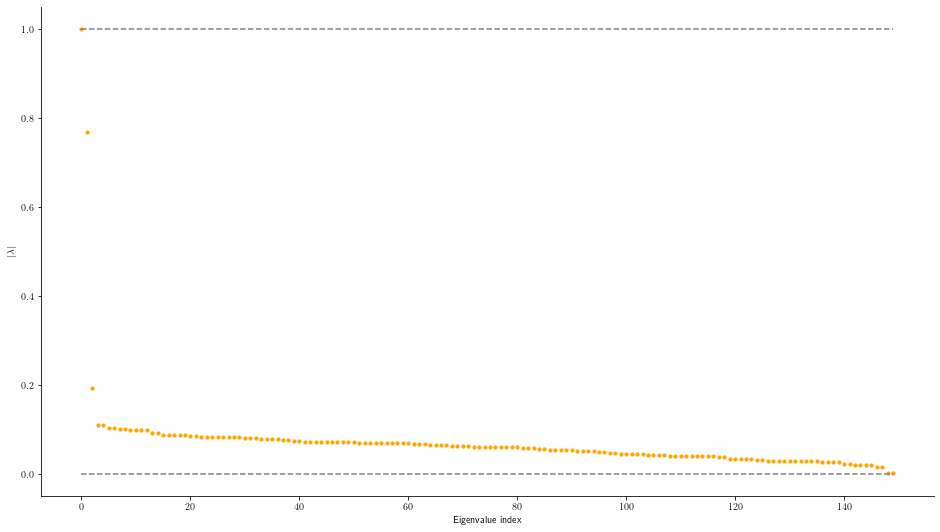

In [10]:
# plotting eigenvalues of the transition matrix
plt.figure(figsize=(16,9))
plt.scatter(np.arange(len(evalues)), np.abs(evalues), marker='o', color='orange', s=10)
plt.hlines(y=1.0, xmin=0, xmax=len(evalues)-1, linestyle='dashed', color='grey')
plt.hlines(y=0.0, xmin=0, xmax=len(evalues)-1, linestyle='dashed', color='grey')
plt.ylabel(r'$|\lambda|$')
plt.xlabel("Eigenvalue index");

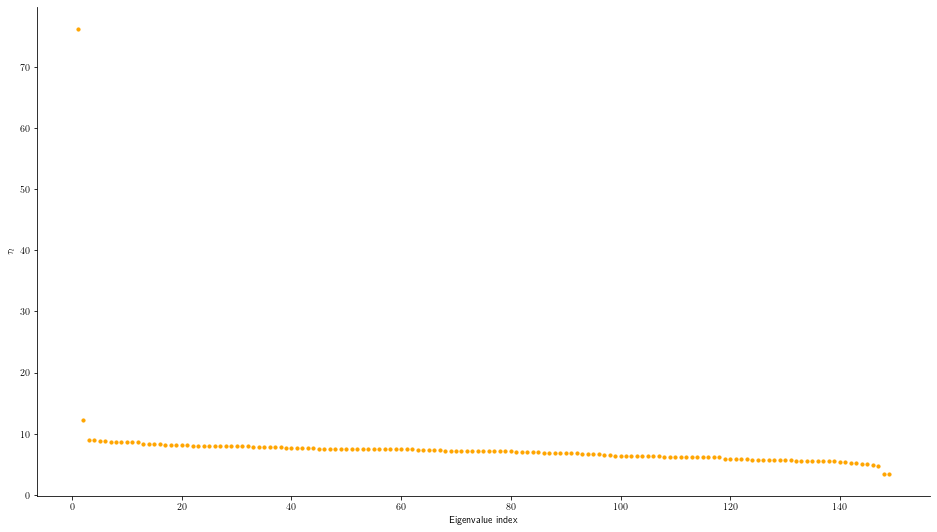

In [11]:
# plotting implicit time scales
plt.figure(figsize=(16,9))
plt.scatter(np.arange(1, len(evalues)), tau_l, marker='o', color='orange', s=10)
plt.ylabel(r'$\tau_l$')
plt.xlabel("Eigenvalue index");

In [12]:
# markov states 
A = np.where(u[:,1]>0)[0]
B = np.where(u[:,1]<0)[0]

4. Visualize the markov states in the space of the two first principal components, or, alternatively, in the coordinates obtained by Isomap.

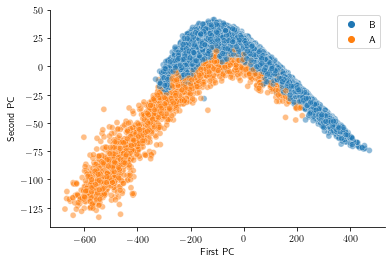

In [13]:
state = np.zeros_like(X[:,0])
for i in B:
    state[np.where(z==i)[0]] = 1
legend_map = {0: 'A', 1: 'B'}
fig = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=pd.Series(state).map(legend_map), alpha=0.5)
fig.set_xlabel('First PC')
fig.set_ylabel('Second PC');

5. Discuss the stability of the results with respect to the metaparameters of the approach, in particular the time lag $\tau$ and the number of clusters. 

In [14]:
def msm_stability(z, tau_min, tau_max):
    tau_ones = []
    for tau in range(tau_min, tau_max):
        P = estimate_P(z, tau)
        evalues, _, _ = transition_eigen(P)
        tau_l = compute_tau_l(tau, evalues)
        tau_ones.append(tau_l[0])
    tau_ones = np.array(tau_ones)
    plt.figure(figsize=(12,3))
    plt.plot(np.arange(tau_min, tau_max), tau_ones)
    plt.ylabel(r'$\tau_1$')
    plt.xlabel(r'$\tau$')
    plt.xticks(np.arange(0, tau_max+1, 5))
    plt.show()

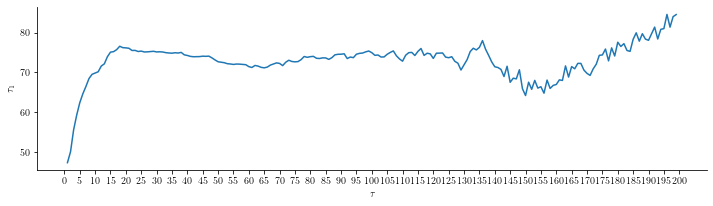

In [15]:
msm_stability(z, 1, 200)

6. Build a multivariate logistic regression model that predicts the Markov state from the original variables.

In [16]:
# reload and center data
X = np.loadtxt('data/airT_dec5.dat')
# train and test split
test_idx = np.arange(int(0.9*X.shape[0]), X.shape[0])
X_train = X[:test_idx[0], :]
X_train = X_train - np.mean(X_train, axis=0)  # centering
label_train = state[:test_idx[0]]
X_test = X[test_idx, :]  
X_test = X_test - np.mean(X_test, axis=0)  # centering
label_test = state[test_idx]

In [17]:
model = LogisticRegression(multi_class='multinomial', max_iter=5000)
model.fit(X_train, label_train)
pred = model.predict(X_test)
print("Mutual information: ", '{:.4f}'.format(mutual_information(label_test, pred)), 
      "Accuracy: ", accuracy_score(label_test, pred, normalize=True))

Mutual information:  0.4996 Accuracy:  0.9759036144578314
